In [35]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json

In [36]:
with open('data.json', 'r') as fp:
    data = json.load(fp)

In [38]:
token_list = []
for song in data:
    token_list.append(data[song])
    

In [43]:
lengths = [len(song) for song in token_list]
min(lengths)


192

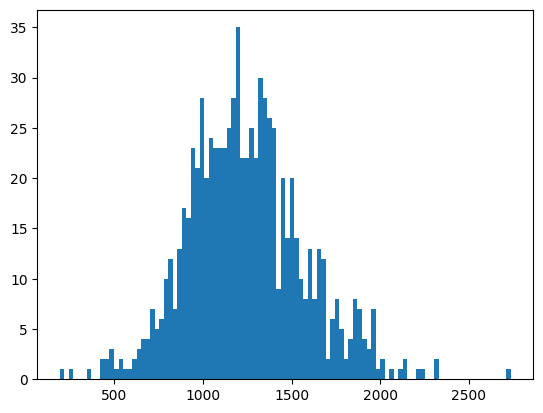

In [45]:
plt.hist(lengths, bins=100)
plt.show()

In [1]:
class Tokenizer:

    def __init__(self):
        self.dictionary = {}
        self.reverse_dictionary = {}

        # Add the padding token
        self.__add_to_dict('<pad>')

        # Add characters and numbers to the dictionary
        for i in range(10):
            self.__add_to_dict(str(i))
        for i in range(26):
            self.__add_to_dict(chr(ord('a') + i))

        # Add space and punctuation to the dictionary
        self.__add_to_dict('.')
        self.__add_to_dict(' ')

    def __add_to_dict(self, character):
        if character not in self.dictionary:
            self.dictionary[character] = len(self.dictionary)
            self.reverse_dictionary[self.dictionary[character]] = character

    def tokenize(self, text):
        return [self.dictionary[c] for c in text]

    def character_to_token(self, character):
        return self.dictionary[character]

    def token_to_character(self, token):
        return self.reverse_dictionary[token]

    def size(self):
        return len(self.dictionary)

In [5]:
class TokenEmbedding(torch.nn.Module):
    """
    Pytorch module that converts tokens into embeddings.

    Input dimension is: (batch_size, sequence_length)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_tokens
    ):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings=number_of_tokens,
            embedding_dim=embedding_dimension
        )

    def forward(self, x):
        return self.embedding_layer(x)

In [6]:
class PositionalEncoding(torch.nn.Module):
    """
    Pytorch module that creates a positional embedding with the same dimensions as the token embeddings.
    """

    def __init__(self, embedding_dimension, max_sequence_length):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self.create_positional_encoding()

    def create_positional_encoding(self):
        """
        Creates a positional encoding matrix of size (max_sequence_length, embedding_dimension)
        """
        positional_encoding = np.zeros((self.max_sequence_length, self.embedding_dimension))
        for pos in range(self.max_sequence_length):
            for i in range(0, self.embedding_dimension, 2):
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.embedding_dimension)))
                positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / self.embedding_dimension)))
        return torch.from_numpy(positional_encoding).float()

    def forward(self, x):
        """
        Adds the positional encoding to the token embeddings.
        """
        return x + self.positional_encoding[:x.size(0), :]

In [7]:
class MaskedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a self attention layer.
    This layer is used in the MultiHeadedSelfAttention module.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, head_dimension)
    """

    def __init__(self, embedding_dimension, head_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        self.query_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.key_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.value_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, mask):
        """
        Compute the self attention.

        x dimension is: (batch_size, sequence_length, embedding_dimension)
        output dimension is: (batch_size, sequence_length, head_dimension)
        mask dimension is: (batch_size, sequence_length)

        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # x dimensions are: (batch_size, sequence_length, embedding_dimension)
        # query, key, value dimensions are: (batch_size, sequence_length, head_dimension)
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Calculate the attention weights.
        # attention_weights dimensions are: (batch_size, sequence_length, sequence_length)
        attention_weights = torch.matmul(query, key.transpose(-2, -1))

        # Scale the attention weights.
        attention_weights = attention_weights / np.sqrt(self.head_dimension)

        # Apply the mask to the attention weights, by setting the masked tokens to a very low value.
        # This will make the softmax output 0 for these values.
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
        # attention_scores dimensions are: (batch_size, sequence_length, sequence_length)
        attention_scores = self.softmax(attention_weights)

        # The attention scores are multiplied by the value
        # Values of tokens with high attention score get highlighted because they are multiplied by a larger number,
        # and tokens with low attention score get drowned out because they are multiplied by a smaller number.
        # Output dimensions are: (batch_size, sequence_length, head_dimension)
        return torch.bmm(attention_scores, value)

In [8]:
class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a multi head attention layer.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(self, embedding_dimension, number_of_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = embedding_dimension // number_of_heads
        self.number_of_heads = number_of_heads

        # Create the self attention modules
        self.self_attentions = torch.nn.ModuleList(
            [MaskedSelfAttention(embedding_dimension, self.head_dimension) for _ in range(number_of_heads)])

        # Create a linear layer to combine the outputs of the self attention modules
        self.output_layer = torch.nn.Linear(number_of_heads * self.head_dimension, embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the multi head attention.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """
        # Compute the self attention for each head
        # self_attention_outputs dimensions are:
        # (number_of_heads, batch_size, sequence_length, head_dimension)
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]

        # Concatenate the self attention outputs
        # self_attention_outputs_concatenated dimensions are:
        # (batch_size, sequence_length, number_of_heads * head_dimension)
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)

        # Apply the output layer to the concatenated self attention outputs
        # output dimensions are: (batch_size, sequence_length, embedding_dimension)
        return self.output_layer(concatenated_self_attention_outputs)

In [9]:
class DecoderLayer(torch.nn.Module):
    """
    Pytorch module for an encoder layer.

    An encoder layer consists of a multi-headed self attention layer, a feed forward layer and dropout.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate

        self.multi_headed_self_attention = MaskedMultiHeadedSelfAttention(embedding_dimension, number_of_heads)
        self.feed_forward = FeedForward(embedding_dimension, feed_forward_dimension)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer_normalization_1 = torch.nn.LayerNorm(embedding_dimension)
        self.layer_normalization_2 = torch.nn.LayerNorm(embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the encoder layer.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # Layer normalization 1
        normalized_x = self.layer_normalization_1(x)

        # Multi headed self attention
        attention_output = self.multi_headed_self_attention(normalized_x, mask)

        # Residual output
        residual_output = x + attention_output

        # Layer normalization 2
        normalized_residual_output = self.layer_normalization_2(residual_output)

        # Feed forward
        feed_forward_output = self.feed_forward(normalized_residual_output)

        # Dropout, only when training.
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)

        # Residual output
        return residual_output + feed_forward_output

In [10]:
class DecoderStack(torch.nn.Module):
    """
    Pytorch module for a stack of decoders.
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_layers,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate,
            max_sequence_length
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        self.max_sequence_length = max_sequence_length

        # Create the encoder layers
        self.encoder_layers = torch.nn.ModuleList(
            [DecoderLayer(embedding_dimension, number_of_heads, feed_forward_dimension, dropout_rate) for _ in
             range(number_of_layers)])

    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.encoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)

        return decoder_outputs

In [11]:
class FeedForward(torch.nn.Module):
    """
    Pytorch module for a feed forward layer.

    A feed forward layer is a fully connected layer with a ReLU activation function in between.
    """

    def __init__(self, embedding_dimension, feed_forward_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.feed_forward_dimension = feed_forward_dimension
        self.linear_1 = torch.nn.Linear(embedding_dimension, feed_forward_dimension)
        self.linear_2 = torch.nn.Linear(feed_forward_dimension, embedding_dimension)

    def forward(self, x):
        """
        Compute the feed forward layer.
        """
        return self.linear_2(torch.relu(self.linear_1(x)))

In [12]:
class LanguageModel(torch.nn.Module):
    """
    Pytorch module for a language model.
    """

    def __init__(
            self,
            number_of_tokens,  # The number of tokens in the vocabulary
            max_sequence_length=512,  # The maximum sequence length to use for attention
            embedding_dimension=512,  # The dimension of the token embeddings
            number_of_layers=6,  # The number of decoder layers to use
            number_of_heads=4,  # The number of attention heads to use
            feed_forward_dimension=None,  # The dimension of the feed forward layer
            dropout_rate=0.1  # The dropout rate to use
    ):
        super().__init__()
        self.number_of_tokens = number_of_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads

        if feed_forward_dimension is None:
            # GPT-2 paper uses 4 * embedding_dimension for the feed forward dimension
            self.feed_forward_dimension = embedding_dimension * 4
        else:
            self.feed_forward_dimension = feed_forward_dimension

        self.dropout_rate = dropout_rate

        # Create the token embedding layer
        self.token_embedding = TokenEmbedding(embedding_dimension, number_of_tokens)

        # Create the positional encoding layer
        self.positional_encoding = PositionalEncoding(embedding_dimension, max_sequence_length)

        # Create the normalization layer
        self.layer_normalization = torch.nn.LayerNorm(embedding_dimension)

        # Create the decoder stack
        self.decoder = DecoderStack(
            embedding_dimension=embedding_dimension,
            number_of_layers=number_of_layers,
            number_of_heads=number_of_heads,
            feed_forward_dimension=self.feed_forward_dimension,
            dropout_rate=dropout_rate,
            max_sequence_length=max_sequence_length
        )

        # Create the language model head
        self.lm_head = LMHead(embedding_dimension, number_of_tokens)

    def forward(self, x, mask):
        # Compute the token embeddings
        # token_embeddings dimensions are: (batch_size, sequence_length, embedding_dimension)
        token_embeddings = self.token_embedding(x)

        # Compute the positional encoding
        # positional_encoding dimensions are: (batch_size, sequence_length, embedding_dimension)
        positional_encoding = self.positional_encoding(token_embeddings)

        # Post embedding layer normalization
        positional_encoding_normalized = self.layer_normalization(positional_encoding)

        decoder_outputs = self.decoder(positional_encoding_normalized, mask)
        lm_head_outputs = self.lm_head(decoder_outputs)

        return lm_head_outputs

In [13]:
class LMHead(torch.nn.Module):
    """
    Pytorch module for the language model head.
    The language model head is a linear layer that maps the embedding dimension to the vocabulary size.
    """

    def __init__(self, embedding_dimension, number_of_tokens):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_tokens = number_of_tokens
        self.linear = torch.nn.Linear(embedding_dimension, number_of_tokens)

    def forward(self, x):
        """
        Compute the language model head.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        output dimensions are: (batch_size, sequence_length, number_of_tokens)
        """
        # Compute the linear layer
        # linear_output dimensions are: (batch_size, sequence_length, number_of_tokens)
        linear_output = self.linear(x)

        return linear_output

In [14]:
class AutoregressiveWrapper(torch.nn.Module):
    """
    Pytorch module that wraps a GPT model and makes it autoregressive.
    """

    def __init__(self, gpt_model):
        super().__init__()
        self.model = gpt_model
        self.max_sequence_length = self.model.max_sequence_length

    def forward(self, x, mask):
        """
        Autoregressive forward pass
        """
        inp, target = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]

        output = self.model(inp, mask)
        return output, target

    def next_token_probabilities(self, x, mask, temperature=1.0):
        """
        Calculate the token probabilities for the next token in the sequence.
        """
        logits = self.model(x, mask)[:, -1]

        # Apply the temperature
        if temperature != 1.0:
            logits = logits / temperature

        # Apply the softmax
        probabilities = torch.softmax(logits, dim=-1)

        return probabilities

In [48]:
def create_training_sequences(max_sequence_length, tokenized_training_data):
    # Create sequences of length max_sequence_length + 1
    # The last token of each sequence is the target token
    sequences = []
    for i in range(0, len(tokenized_training_data) - max_sequence_length - 1):
        sequences.append(tokenized_training_data[i: i + max_sequence_length + 1])
    return sequences


def tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data):
    # Tokenize the training data
    tokenized_training_data = tokenizer.tokenize(training_data)
    for _ in range(max_sequence_length):
        # Prepend padding tokens
        tokenized_training_data.insert(0, tokenizer.character_to_token('<pad>'))
    return tokenized_training_data


tokenizer = Tokenizer()

embedding_dimension = 256
max_sequence_length = 128
number_of_tokens = 121

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=4,
    number_of_layers=3,
    dropout_rate=0.1,
    max_sequence_length=max_sequence_length
))

In [47]:
class Trainer:

    def __init__(self, model, tokenizer: Tokenizer, optimizer=None):
        super().__init__()
        self.model = model
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        else:
            self.optimizer = optimizer
        self.tokenizer = tokenizer
        self.loss_function = torch.nn.CrossEntropyLoss()

    def train(self, data, epochs, batch_size):
        loss_per_epoch = []
        for epoch in range(epochs):
            losses = []

            # Shuffle the sequences
            random.shuffle(data)

            # Create batches of sequences and their respective mask.
            batches = []
            for i in range(0, len(data), batch_size):
                sequence_tensor = torch.tensor(data[i: i + batch_size], dtype=torch.long)

                # Create the mask tensor for the batch, where 1 means the token is not a padding token
                mask_tensor = torch.ones_like(sequence_tensor)
                mask_tensor[sequence_tensor == self.tokenizer.character_to_token('<pad>')] = 0

                batches.append((sequence_tensor, mask_tensor))

            # Train the model on each batch
            for batch in batches:
                self.model.train()

                # Create the input and mask tensors
                input_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)
                mask_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)

                for i, input_entry in enumerate(batch[0]):
                    input_tensor[i] = input_entry

                for i, mask_entry in enumerate(batch[1]):
                    mask_tensor[i] = mask_entry

                # Compute the model output
                model_output, target = self.model.forward(x=input_tensor, mask=mask_tensor)

                # Compute the losses
                # The loss is computed on the model output and the target
                loss = self.loss_function(model_output.transpose(1, 2), target)

                # Backpropagate the loss.
                loss.backward()

                # Clip the gradients. This is used to prevent exploding gradients.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)

                # Update the model parameters. This is done by taking a step in the direction of the gradient.
                self.optimizer.step()

                # Reset the gradients. This is done so that the gradients from the previous batch
                # are not used in the next step.
                self.optimizer.zero_grad()

                # Append the loss to the list of losses, so that the average loss can be computed for this epoch.
                losses.append(loss.item())

            # Print the loss
            epoch_loss = np.average(losses)
            loss_per_epoch.append(epoch_loss)
            print('Epoch:', epoch, 'Loss:', epoch_loss)

        return loss_per_epoch

In [64]:
def pad_left(sequence, final_length, padding_token):
    return [padding_token] * (final_length - len(sequence)) + sequence


class Generator:

    def __init__(
            self,
            model,
            tokenizer):
        self.model = model
        #self.tokenizer = tokenizer

    def generate(
            self,
            max_tokens_to_generate: int,
            prompt: str = None,
            temperature: float = 1.0,
            eos_token: int = None,
            padding_token: int = 0):

        self.model.eval()

        if prompt is None:
            start_tokens = [120]
        else:
            start_tokens = prompt

        input_tensor = torch.tensor(
            pad_left(
                sequence=start_tokens,
                final_length=self.model.max_sequence_length + 1,
                padding_token=padding_token
            ),
            dtype=torch.long
        )

        num_dims = len(input_tensor.shape)

        if num_dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        for _ in range(max_tokens_to_generate):

            x = out[:, -self.model.max_sequence_length:]

            mask = torch.ones_like(x)
            mask[x == padding_token] = 0

            # Compute the next token probabilities
            next_token_probabilities = self.model.next_token_probabilities(
                x=x,
                temperature=temperature,
                mask=mask
            )

            # Sample the next token from the probability distribution
            next_token = torch.multinomial(next_token_probabilities, num_samples=1)

            # Append the next token to the output
            out = torch.cat([out, next_token], dim=1)

            # If the end of sequence token is reached, stop generating tokens
            if eos_token is not None and next_token == eos_token:
                break

        generated_tokens = out[0].tolist()
        #return ''.join([self.tokenizer.token_to_character(token) for token in generated_tokens])
        return generated_tokens

In [ ]:
# Create the training data
training_data = '. '.join([
    'cats rule the world',
    'dogs are the best',
    'elephants have long trunks',
    'monkeys like bananas',
    'pandas eat bamboo',
    'tigers are dangerous',
    'zebras have stripes',
    'lions are the kings of the savannah',
    'giraffes have long necks',
    'hippos are big and scary',
    'rhinos have horns',
    'penguins live in the arctic',
    'polar bears are white'
])



In [31]:
# Create the training data
training_data = '. '.join([
    'cats rule the world',
    'dogs are the best',
    'elephants have long trunks',
    'monkeys like bananas',
    'pandas eat bamboo',
    'tigers are dangerous',
    'zebras have stripes',
    'lions are the kings of the savannah',
    'giraffes have long necks',
    'hippos are big and scary',
    'rhinos have horns',
    'penguins live in the arctic',
    'polar bears are white'
])

"""
# Tokenize the training data
tokenized_training_data = tokenizer.tokenize(training_data)

# Add padding to the left, to make sure all parts of the sequence are being trained
for _ in range(max_sequence_length):
    # Prepend padding tokens
    tokenized_training_data.insert(0, tokenizer.character_to_token('<pad>'))
"""

#tokenized_and_padded_training_data = tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data)
#sequences = create_training_sequences(max_sequence_length, tokenized_and_padded_training_data)

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, tokenizer, optimizer)
loss_per_epoch = trainer.train(sequences, epochs=50, batch_size=20)

Epoch: 0 Loss: 0.6269109975546598
Epoch: 1 Loss: 0.574933186173439
Epoch: 2 Loss: 0.518666666932404
Epoch: 3 Loss: 0.4665888287127018
Epoch: 4 Loss: 0.41852995194494724
Epoch: 5 Loss: 0.3721507368609309
Epoch: 6 Loss: 0.32767093926668167
Epoch: 7 Loss: 0.293087022844702
Epoch: 8 Loss: 0.26530141616240144
Epoch: 9 Loss: 0.2332085222005844
Epoch: 10 Loss: 0.20160000678151846
Epoch: 11 Loss: 0.18124062987044454
Epoch: 12 Loss: 0.16243038745597005
Epoch: 13 Loss: 0.13985720975324512
Epoch: 14 Loss: 0.12673934502527118
Epoch: 15 Loss: 0.11625302955508232
Epoch: 16 Loss: 0.10446816170588136
Epoch: 17 Loss: 0.0885671831201762
Epoch: 18 Loss: 0.08252928359434009
Epoch: 19 Loss: 0.07406864268705249
Epoch: 20 Loss: 0.0674691058229655
Epoch: 21 Loss: 0.06339816865511239
Epoch: 22 Loss: 0.06056331645231694
Epoch: 23 Loss: 0.05549391754902899
Epoch: 24 Loss: 0.044843315496109426
Epoch: 25 Loss: 0.0481273754267022
Epoch: 26 Loss: 0.044788877828978
Epoch: 27 Loss: 0.03854639397468418
Epoch: 28 Loss: 

## Ab hier für Musik

In [73]:
embedding_dimension = 256
max_sequence_length = 128
number_of_tokens = 121

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=4,
    number_of_layers=3,
    dropout_rate=0.1,
    max_sequence_length=max_sequence_length
))

In [74]:
sequences = [ [120] + song[:max_sequence_length] for song in token_list ]

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, tokenizer, optimizer)
loss_per_epoch = trainer.train(sequences, epochs=100, batch_size=20)

Epoch: 0 Loss: 4.603653975895473
Epoch: 1 Loss: 3.519871950149536
Epoch: 2 Loss: 3.0146497317722867
Epoch: 3 Loss: 2.6324515513011386
Epoch: 4 Loss: 2.3604329994746616
Epoch: 5 Loss: 2.157393600259508
Epoch: 6 Loss: 2.0098560452461243
Epoch: 7 Loss: 1.9010136127471924
Epoch: 8 Loss: 1.8207486016409737
Epoch: 9 Loss: 1.7591780253819056
Epoch: 10 Loss: 1.7070641347340174
Epoch: 11 Loss: 1.6606709786823817
Epoch: 12 Loss: 1.6245412698813848
Epoch: 13 Loss: 1.5981905928679876
Epoch: 14 Loss: 1.5767116716929845
Epoch: 15 Loss: 1.5574599632195063
Epoch: 16 Loss: 1.5419460918222154
Epoch: 17 Loss: 1.5288148096629552
Epoch: 18 Loss: 1.514701519693647
Epoch: 19 Loss: 1.5043810989175523
Epoch: 20 Loss: 1.4931631003107344
Epoch: 21 Loss: 1.4830221235752106
Epoch: 22 Loss: 1.473379863159997
Epoch: 23 Loss: 1.464551819222314
Epoch: 24 Loss: 1.4553556314536504
Epoch: 25 Loss: 1.447263947554997
Epoch: 26 Loss: 1.4391339123249054
Epoch: 27 Loss: 1.4322861731052399
Epoch: 28 Loss: 1.425113673721041
Epo

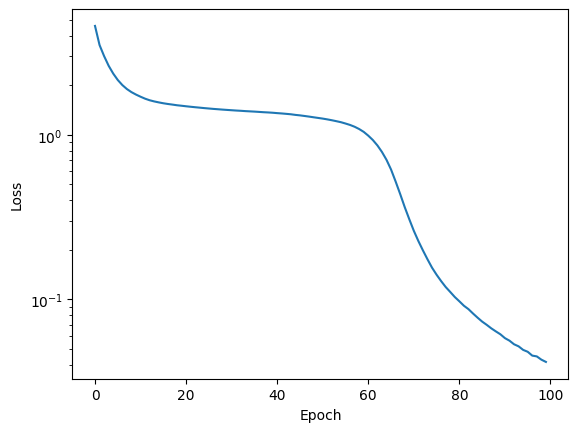

In [78]:
plt.plot(loss_per_epoch)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [79]:
max_tokens_to_generate = 50
generator = Generator(model, tokenizer)
generated_text = generator.generate(
    max_tokens_to_generate=32,
    prompt=[0],
    padding_token=120
)
print(generated_text)

[120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
